In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14



In [3]:
modelFile = '../model/res10_300x300_ssd_iter_140000.caffemodel'
configFile = '../model/deploy.prototxt'

# Read the model and create a network object.
net = cv2.dnn.readNetFromCaffe(prototxt=configFile, caffeModel=modelFile)

In [4]:
def blur(face, factor=3):
    
    h, w  = face.shape[:2]
    print(face.shape)
    if factor < 1: factor = 1 # Maximum blurring
    if factor > 5: factor = 5 # Minimal blurring
    
    # Kernel size.
    w_k = int(w/factor)
    h_k = int(h/factor)

    # Insure kernel is an odd number.
    if w_k%2 == 0: w_k += 1 
    if h_k%2 == 0: h_k += 1 

    blurred = cv2.GaussianBlur(face, (int(w_k), int(h_k)), 0, 0)
    return blurred 

In [48]:
def face_blur_rect(image, net, factor=3, detection_threshold=0.9):
    
    img = image.copy()
    img1 = image.copy()
        
    # Convert the image into a blob format.
    blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(300,300), mean=[104, 117, 123])
    
    # Pass the blob to the DNN model.
    net.setInput(blob)
    
    # Retrieve detections from the DNN model.
    detections = net.forward()
    
    (h, w) = img.shape[:2]
    
    # List to store class IDs with unique identifiers.
    unique_ids = []
    
    # Process the detections to store unique identifiers and draw bounding boxes.
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > detection_threshold:
            class_id = detections[0, 0, i, 1]
            unique_id = f"{int(class_id)}_{i+1}"
            unique_ids.append(unique_id)
            
            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")
            
            # Draw the bounding box.
            cv2.rectangle(img1, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Display the unique ID at the center of the bounding box.
            center_x, center_y = (x1 + x2) // 2, (y1 + y2) // 2
            cv2.putText(img1, unique_id, (center_x - 20, center_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # Display the image with bounding boxes and unique IDs.
    cv2.imshow("Detected Faces", img1)
    
    # Keep the window open until the user presses the 'q' key.
    while True:
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()

    # Ask the user which unique ID they don't want to blur.
    print(f"Detected unique IDs: {unique_ids}")
    skip_id = input("Enter the unique ID you don't want to blur (e.g., 1_2): ")
    
    # Process the detections to blur the faces.
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        class_id = detections[0, 0, i, 1]
        unique_id = f"{int(class_id)}_{i+1}"
        if confidence > detection_threshold and unique_id != skip_id:
            
            # Extract the bounding box coordinates from the detection.
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")

            # Extract the face ROI.
            face = img[y1:y2, x1:x2]

            face = blur(face, factor=factor)

            # Replace the detected face with the blurred one.
            img[y1:y2, x1:x2] = face
            
    return img

In [ ]:
img1 = cv2.imread('family.jpg', cv2.IMREAD_COLOR)

Detected unique IDs: ['1_1', '1_2', '1_3', '1_4', '1_5', '1_6', '1_7']
(92, 70, 3)
(58, 56, 3)
(77, 59, 3)
(73, 59, 3)
(73, 58, 3)
(77, 57, 3)


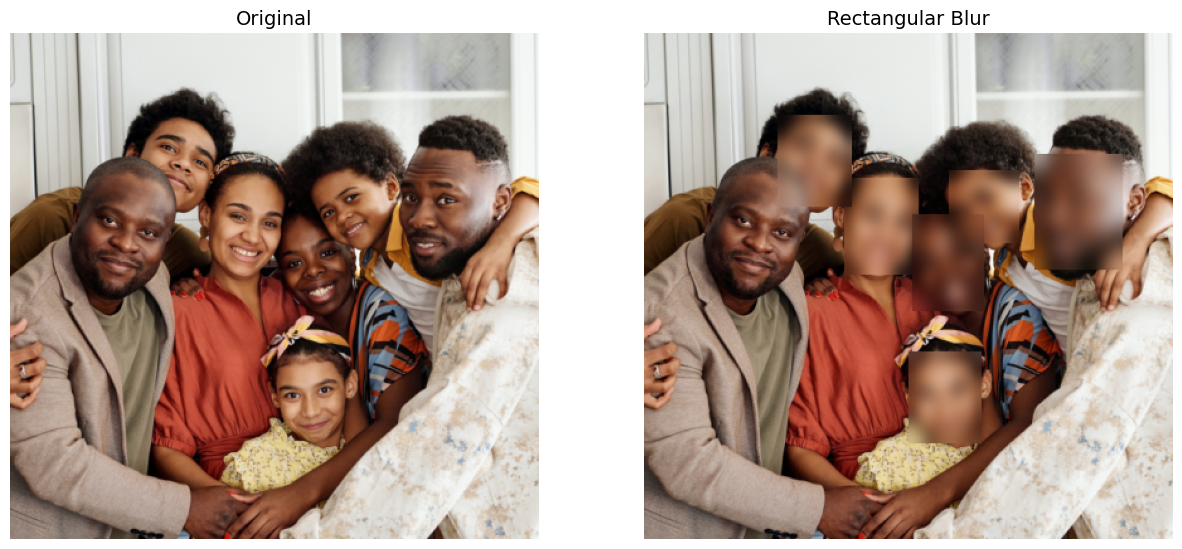

In [49]:
img1_rect = face_blur_rect(img1, net, factor=2)

fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1); plt.axis('off'); plt.imshow(img1[:,:,::-1]);      plt.title('Original')
plt.subplot(1,2,2); plt.axis('off'); plt.imshow(img1_rect[:,:,::-1]); plt.title('Rectangular Blur');